In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import joblib
import pickle
import torch
from xgboost import XGBRegressor
from darts import TimeSeries
from darts.models import  RandomForest, LinearRegressionModel,  \
                        LightGBMModel, CatBoostModel, XGBModel,  \
                        BlockRNNModel, NBEATSModel, NHiTSModel, \
                        TCNModel, TFTModel
from sklearn.svm import SVR
from sklearn.linear_model import PoissonRegressor

from darts.dataprocessing.transformers import Scaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from darts.utils.likelihood_models import GaussianLikelihood

import warnings
warnings.filterwarnings('ignore')

/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configuration

In [2]:
prj_path = '../'
data_path = prj_path + "data/new_data/DH/squeezed/"
prj_path_opt= prj_path + "optimize_hyperparam/opt_results/"
output_process = prj_path + "data/new_data/DH/processed_data/"
output_featureselection = prj_path + "data/new_data/DH/feature_selection/"
model_path = "../predict_model/trained_models/"

In [3]:
all_cities = [
        'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh',
        'Hòa Bình','Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn','Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
        'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp'
]
cities = ['Hà Nội','Hải Phòng','Quảng Ninh','Nam Định','Thái Bình','Quảng Nam','Quảng Ngãi', 'Phú Yên',
          'Ninh Thuận', 'Bình Thuận', 'Tây Ninh', 'Bình Phước', 'An Giang', 'Tiền Giang','Cần Thơ', 'Trà Vinh','Kiên Giang','Sóc Trăng','Bạc Liêu','Cà Mau']
missing_cities = [ 'Bạc Liêu','Cà Mau','Kiên Giang','Sóc Trăng']
cities = ['Hà Nội','Hải Phòng','Quảng Ninh','Nam Định','Thái Bình','Quảng Nam','Quảng Ngãi', 'Phú Yên',
          'Ninh Thuận', 'Bình Thuận', 'Tây Ninh', 'Bình Phước', 'An Giang', 'Tiền Giang','Cần Thơ', 'Trà Vinh']
cities =['An Giang','Bình Phước']
data_set = {
  0: "test",
  1: "train"
}

In [4]:
# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
        # lấy bộ test dài 36 tháng = 3 năm
        self.test_size = 36
        self.df_train_full_size = 203
        self.df_test_full_size = 44
        # là nhìn vào dữ liệu trước 3 tháng và dự phóng        
        self.look_back = 3
        # dự phóng n-step trong 6 tháng
        self.n_predicted_period_months = 6
        self.n_features = 3
        self.seed = 42
        # mỗi phần tử x trong tập suppervise có độ lớn là 16 = 16 tháng
        self.batch_size = 16
        self.device = torch.device("cuda")
        self.epochs = 300
        #others
        self.labels = "Dengue_fever_rates"
        # Input param for Optimize Run
        self.ntry = 1
        self.njob = 1

args = Configuration()

# Seeding

In [5]:
def seed_everything(seed: int):
    import random
    import numpy as np
    import torch
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(args.seed)

# Supporting functions

In [6]:
import requests

def send_to_telegram(message):

    apiToken = '5908735099:AAGVSLrW62aXPBP-GrMvxoVgMsuJxXJpP1Q'
    chatID = '@ptn_announcement'
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

    try:
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
        print(response.text)
    except Exception as e:
        message_error = "Bị lỗi rùi: "+str(e)
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message_error})
        print(e)

In [7]:
def get_dict_all_city_data():
  cities_data = {}  
  for city in cities:
    city_result = pd.read_excel(prj_path+'data/new_data/DH/squeezed/squeezed_'+city+'.xlsx')  
    """Get all data from all city in 1997 - 2016""" 
    city_result = city_result.loc[city_result['year_month'] < '2017-1-1'] 
    cities_data[city] = city_result
  return cities_data

In [8]:
# Define data (pre-)processing functions
# modification
def get_city_data(city_name, dict_full_data):
    """Returns Diarrhoea rate and climate data""" 
    city_data = dict_full_data[city_name].drop(columns=['Diarrhoea_cases','Diarrhoea_rates', 'province',
                                                        'Influenza_rates','Influenza_cases',
                                                        'Dengue_fever_cases', 'year', 'month'], 
                                                                  axis=1, 
                                                                  inplace=False)    
    return city_data

def convert_to_stationary(city_data):
    """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Diarrhoea_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Imputes 0 for first 12 months, 
    last year's value for months 12-24, 
    and minimum value of last two years for months 25+
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

In [9]:
def clean_full_data(dict_full_data):
    climate_and_disease_feats = ['Total_Evaporation',
       'Total_Rainfall', 'Max_Daily_Rainfall', 'n_raining_days',
       'Average_temperature', 'Max_Average_Temperature',
       'Min_Average_Temperature', 'Max_Absolute_Temperature',
       'Min_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity',
       'n_hours_sunshine', 'Dengue_fever_rates']
    for city in cities:
        city_data = get_city_data(city_name=city,dict_full_data = dict_full_data)
        city_data_features = city_data[climate_and_disease_feats]
        city_data_features = impute_missing_value(city_data_features)
        city_data_features = convert_to_stationary(city_data_features)
        city_data_features.dropna(inplace=True)
        city_data_features.loc[:, "year_month"] = city_data["year_month"]
        dict_full_data[city] = city_data_features
    return dict_full_data


In [10]:
def to_supervised(data,  d_out, d_in, features_list=[]):
    """
    Frames time-series as supervised learning dataset.
    
    Args:
      d_in: lookback window
      d_out: number of predicted months
      features_list: list of all features **where last col is the disease incidence**

    Returns:
      Numpy arrays of disease incidence (y) and other predictors (X)
    """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            if len(features_list) == 0 :
                X.append(data[index: in_end, :-1])
            else:
                X.append(data[index: in_end, features_list])
            y.append(data[out_end-1: out_end, -1])
    return np.array(X), np.array(y).reshape(len(y))

In [11]:
def getDataWithSelectedFeature(city, next_predicted_month):
  selected_feature = []
  df = pd.read_csv(output_featureselection+str(next_predicted_month)+"step_feature_selection_3_most.csv")
  for row in range(len(df)):
    if (df["City"][row] == city):
      selected_feature.append(df["1st_Feature"][row])
      selected_feature.append(df["2nd_Feature"][row])
      selected_feature.append(df["3rd_Feature"][row])
  return selected_feature

In [12]:
def getHyperParams(model_name, city, nstep):
  folder_path = f'../optimize_hyperparam/opt_results/opt_res_ml_26102023/{model_name}/'
  file_path = folder_path+ f'261023_DF_opt_hyperparam_{model_name}_{nstep}-nstep.xlsx'
  df_optimized = pd.read_excel(file_path)
  display(df_optimized)
  df_optimized_params = df_optimized.loc[(df_optimized['City'] == city)]
  return df_optimized_params

In [13]:
def getHyperParamsForMultiOutput(model_name, city):
  folder_path = f'../optimize_hyperparam/opt_results/opt_res_ml_26102023/{model_name}/'
  file_path = folder_path+ f'261023_DF_opt_hyperparam_{model_name}_multi-nstep.xlsx'
  df_optimized = pd.read_excel(file_path)
  df_optimized_params = df_optimized.loc[(df_optimized['City'] == city)]
  return df_optimized_params

In [14]:
import datetime
import calendar
from dateutil import relativedelta

def retime_train(start_date, len_train):
    datetime_start = start_date
    nextmonth = datetime_start
    retime_list = []
    for i in range(1,len_train+1):
        nextmonth = datetime.datetime.strptime(nextmonth, '%Y-%m-%d') + relativedelta.relativedelta(months=1)
        year_of_datetime = nextmonth.year
        month_of_datetime = nextmonth.month
        lastday_of_datetime = calendar.monthrange(year_of_datetime, month_of_datetime)[1]
        nextmonth = f"{year_of_datetime}-{month_of_datetime}-{lastday_of_datetime}"

        retime_list.append(datetime.datetime.strptime(nextmonth, '%Y-%m-%d'))
    
    return retime_list

# Load results for one-step-output model

⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️XGBModel⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨1✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝
🐝Predict test nèkk
Total len(_test) is 36/36


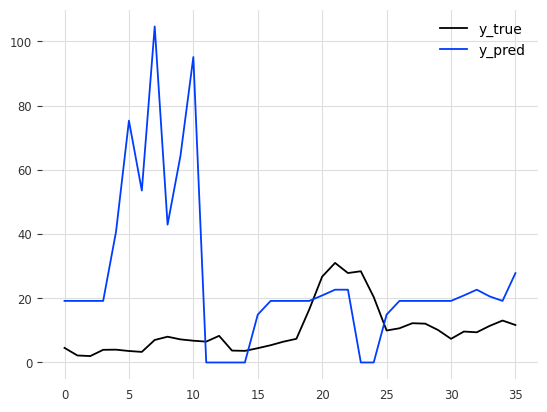

✨✨✨✨✨✨✨✨2✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝
🐝Predict test nèkk
Total len(_test) is 36/36


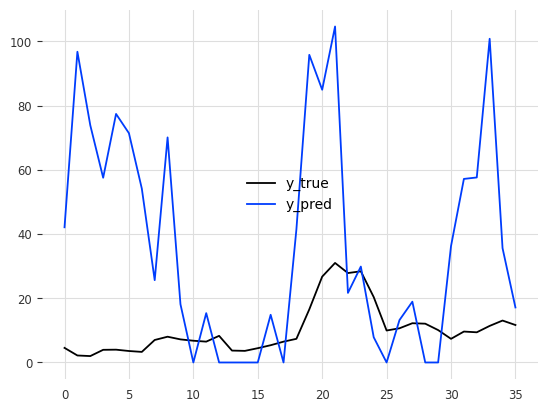

✨✨✨✨✨✨✨✨3✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝
🐝Predict test nèkk
Total len(_test) is 36/36


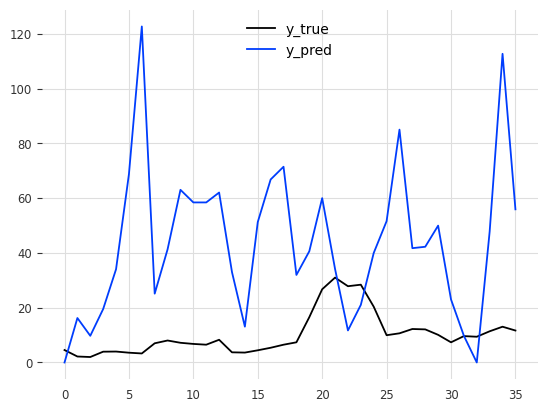

✨✨✨✨✨✨✨✨4✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝
🐝Predict test nèkk
Total len(_test) is 36/36


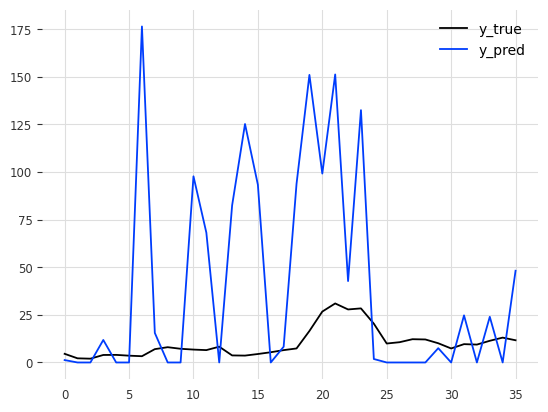

✨✨✨✨✨✨✨✨5✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝
🐝Predict test nèkk
Total len(_test) is 36/36


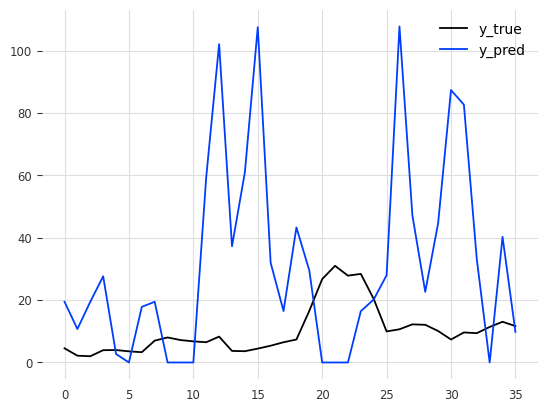

✨✨✨✨✨✨✨✨6✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝
🐝Predict test nèkk
Total len(_test) is 36/36


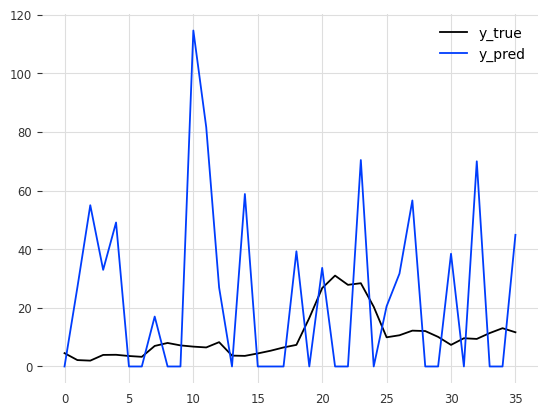

✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨1✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝
🐝Predict test nèkk
Total len(_test) is 36/36


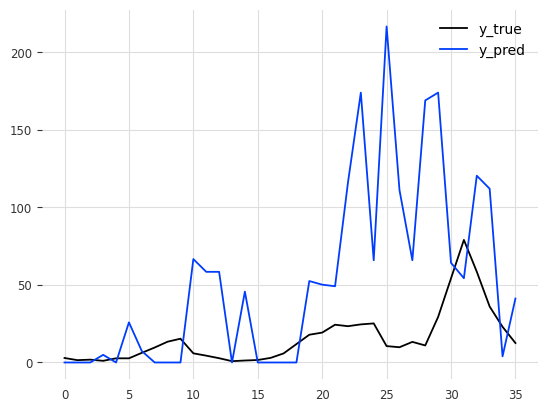

✨✨✨✨✨✨✨✨2✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝
🐝Predict test nèkk
Total len(_test) is 36/36


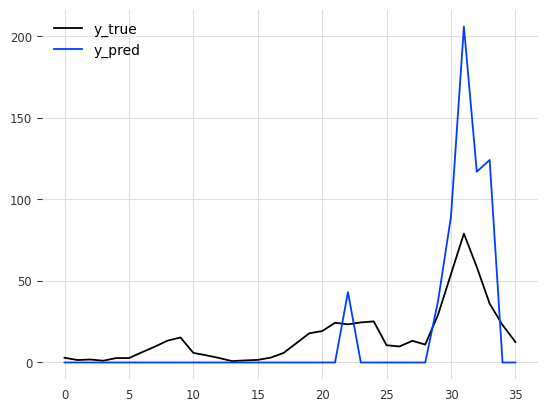

✨✨✨✨✨✨✨✨3✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝
🐝Predict test nèkk
Total len(_test) is 36/36


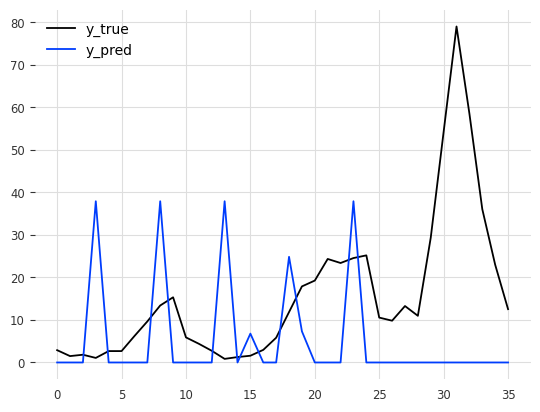

✨✨✨✨✨✨✨✨4✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝
🐝Predict test nèkk
Total len(_test) is 36/36


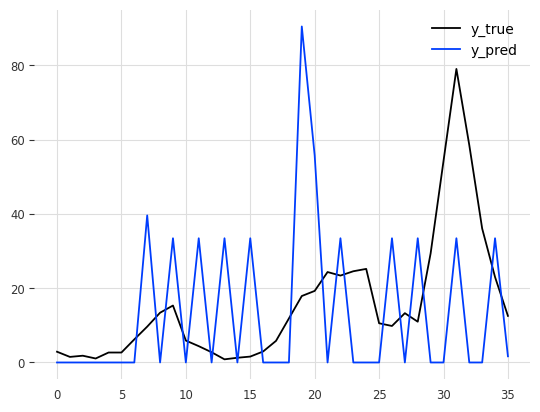

✨✨✨✨✨✨✨✨5✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝
🐝Predict test nèkk
Total len(_test) is 36/36


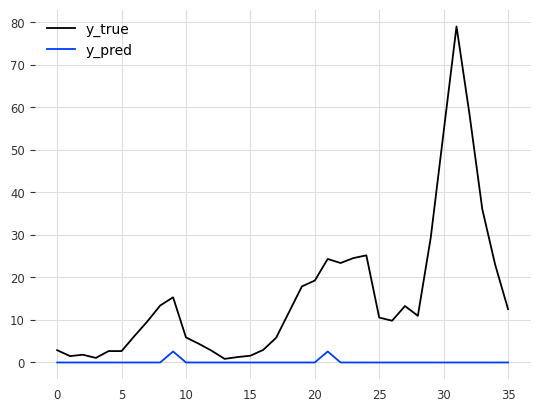

✨✨✨✨✨✨✨✨6✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝
🐝Predict test nèkk
Total len(_test) is 36/36


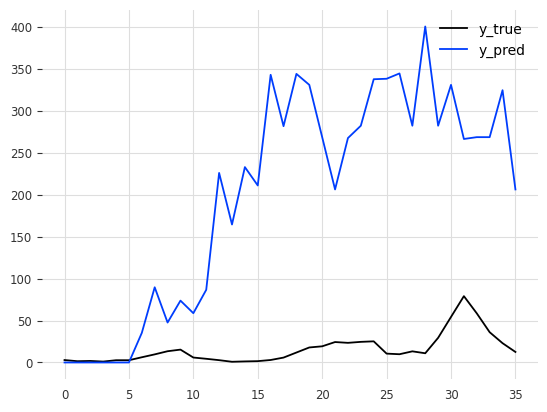

⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️XGBModel⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨1✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝


XGBModel(lags=3, lags_past_covariates=[-1, -2, -3], lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=quantile, quantiles=None, random_state=2, multi_models=True, use_static_covariates=True)

🐝Predict train nèkk
🐹🐹🐹🐹🐹🐹🐹🐹 df_train_year_month: 195
🌷 <TimeSeries (DataArray) (year_month: 198, component: 3, sample: 1)>
array([[[0.354023 ],
        [0.804878 ],
        [0.071    ]],

       [[0.6258621],
        [0.4146341],
        [0.7155   ]],

       [[0.3436782],
        [0.4390244],
        [0.593    ]],

       [[0.4241379],
        [0.7073171],
        [0.7105   ]],

       [[0.4695402],
        [0.4634146],
        [0.552    ]],

...

       [[0.4942529],
        [0.5609756],
        [0.695    ]],

       [[0.2758621],
        [0.5609756],
        [0.44     ]],

       [[0.4655172],
        [0.5609756],
        [0.83     ]],

       [[0.5      ],
        [0.5609756],
        [0.65     ]],

       [[0.5747126],
        [0.5609756],
        [0.61     ]]])
Coordinates:
  * year_month  (year_month) datetime64[ns] 2013-10-31 2013-11-30 ... 2030-03-31
  * component   (component) object 'Total_Evaporation' ... 'n_hours_sunshine'
Dimensions without coordinates: sample
Attributes

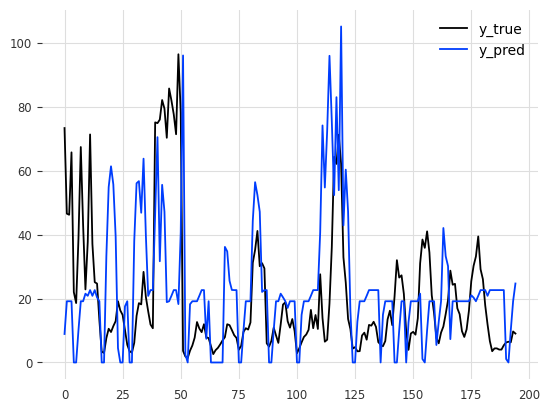

✨✨✨✨✨✨✨✨2✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝


XGBModel(lags=4, lags_past_covariates=[-2, -3, -4], lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=quantile, quantiles=None, random_state=41, multi_models=True, use_static_covariates=True)

🐝Predict train nèkk
🐹🐹🐹🐹🐹🐹🐹🐹 df_train_year_month: 195
🌷 <TimeSeries (DataArray) (year_month: 199, component: 3, sample: 1)>
array([[[0.6011494],
        [0.6341463],
        [0.425    ]],

       [[0.354023 ],
        [0.804878 ],
        [0.375    ]],

       [[0.6258621],
        [0.4146341],
        [0.4875   ]],

       [[0.3436782],
        [0.4390244],
        [0.3875   ]],

       [[0.4241379],
        [0.7073171],
        [0.375    ]],

...

       [[0.4942529],
        [0.5609756],
        [0.375    ]],

       [[0.2758621],
        [0.5609756],
        [0.55     ]],

       [[0.4655172],
        [0.5609756],
        [0.3125   ]],

       [[0.5      ],
        [0.5609756],
        [0.4125   ]],

       [[0.5747126],
        [0.5609756],
        [0.4      ]]])
Coordinates:
  * year_month  (year_month) datetime64[ns] 2013-09-30 2013-10-31 ... 2030-03-31
  * component   (component) object 'Total_Evaporation' ... 'Max_Absolute_Temp...
Dimensions without coordinates: sample
Attribu

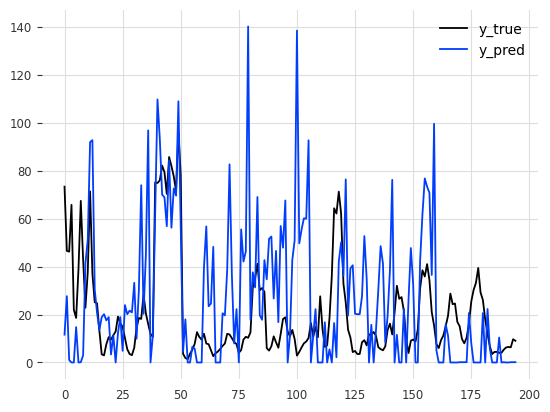

✨✨✨✨✨✨✨✨3✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝


XGBModel(lags=5, lags_past_covariates=[-3, -4, -5], lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=quantile, quantiles=None, random_state=37, multi_models=True, use_static_covariates=True)

🐝Predict train nèkk
🐹🐹🐹🐹🐹🐹🐹🐹 df_train_year_month: 195
🌷 <TimeSeries (DataArray) (year_month: 200, component: 3, sample: 1)>
array([[[0.6585366],
        [0.3875   ],
        [0.5      ]],

       [[0.6341463],
        [0.425    ],
        [0.45     ]],

       [[0.804878 ],
        [0.375    ],
        [0.7      ]],

       [[0.4146341],
        [0.4875   ],
        [0.35     ]],

       [[0.4390244],
        [0.3875   ],
        [0.35     ]],

...

       [[0.5609756],
        [0.375    ],
        [0.35     ]],

       [[0.5609756],
        [0.55     ],
        [0.45     ]],

       [[0.5609756],
        [0.3125   ],
        [0.35     ]],

       [[0.5609756],
        [0.4125   ],
        [0.25     ]],

       [[0.5609756],
        [0.4      ],
        [0.25     ]]])
Coordinates:
  * year_month  (year_month) datetime64[ns] 2013-08-31 2013-09-30 ... 2030-03-31
  * component   (component) object 'n_raining_days' ... 'Average_Humidity'
Dimensions without coordinates: sample
Attributes:
 

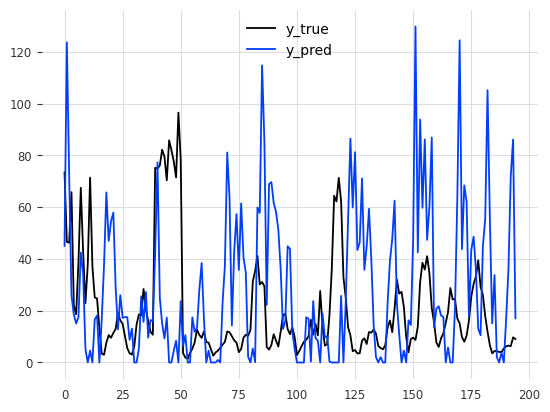

✨✨✨✨✨✨✨✨4✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝


XGBModel(lags=6, lags_past_covariates=[-4, -5, -6], lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=quantile, quantiles=None, random_state=17, multi_models=True, use_static_covariates=True)

🐝Predict train nèkk
🐹🐹🐹🐹🐹🐹🐹🐹 df_train_year_month: 195
🌷 <TimeSeries (DataArray) (year_month: 201, component: 3, sample: 1)>
array([[[0.5004355],
        [0.7073171],
        [0.6875   ]],

       [[0.4995645],
        [0.6585366],
        [0.3875   ]],

       [[0.320122 ],
        [0.6341463],
        [0.425    ]],

       [[0.5383275],
        [0.804878 ],
        [0.375    ]],

       [[0.3758711],
        [0.4146341],
        [0.4875   ]],

...

       [[0.4015679],
        [0.5609756],
        [0.375    ]],

       [[0.4930314],
        [0.5609756],
        [0.55     ]],

       [[0.4756098],
        [0.5609756],
        [0.3125   ]],

       [[0.2447735],
        [0.5609756],
        [0.4125   ]],

       [[0.5235192],
        [0.5609756],
        [0.4      ]]])
Coordinates:
  * year_month  (year_month) datetime64[ns] 2013-07-31 2013-08-31 ... 2030-03-31
  * component   (component) object 'Max_Daily_Rainfall' ... 'Max_Absolute_Tem...
Dimensions without coordinates: sample
Attribu

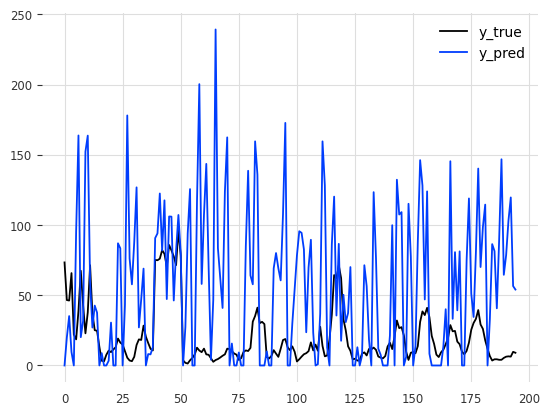

✨✨✨✨✨✨✨✨5✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝


XGBModel(lags=7, lags_past_covariates=[-5, -6, -7], lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=quantile, quantiles=None, random_state=19, multi_models=True, use_static_covariates=True)

🐝Predict train nèkk
🐹🐹🐹🐹🐹🐹🐹🐹 df_train_year_month: 195
🌷 <TimeSeries (DataArray) (year_month: 202, component: 3, sample: 1)>
array([[[0.4181185],
        [0.7125   ],
        [0.9885   ]],

       [[0.5004355],
        [0.6875   ],
        [0.28     ]],

       [[0.4995645],
        [0.3875   ],
        [0.521    ]],

       [[0.320122 ],
        [0.425    ],
        [0.642    ]],

       [[0.5383275],
        [0.375    ],
        [0.071    ]],

...

       [[0.4015679],
        [0.375    ],
        [0.695    ]],

       [[0.4930314],
        [0.55     ],
        [0.44     ]],

       [[0.4756098],
        [0.3125   ],
        [0.83     ]],

       [[0.2447735],
        [0.4125   ],
        [0.65     ]],

       [[0.5235192],
        [0.4      ],
        [0.61     ]]])
Coordinates:
  * year_month  (year_month) datetime64[ns] 2013-06-30 2013-07-31 ... 2030-03-31
  * component   (component) object 'Max_Daily_Rainfall' ... 'n_hours_sunshine'
Dimensions without coordinates: sample
Attribute

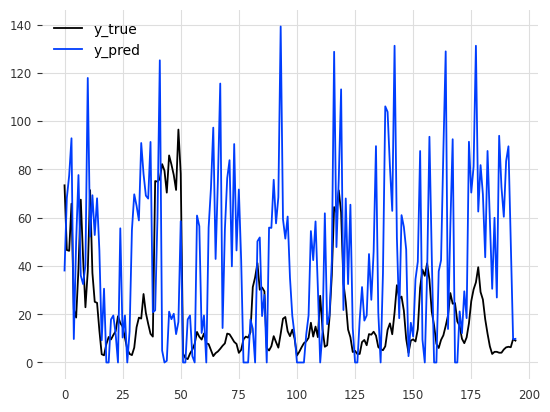

✨✨✨✨✨✨✨✨6✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝


XGBModel(lags=8, lags_past_covariates=[-6, -7, -8], lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=quantile, quantiles=None, random_state=8, multi_models=True, use_static_covariates=True)

🐝Predict train nèkk
🐹🐹🐹🐹🐹🐹🐹🐹 df_train_year_month: 195
🌷 <TimeSeries (DataArray) (year_month: 203, component: 3, sample: 1)>
array([[[0.4281359],
        [0.55     ],
        [0.45     ]],

       [[0.4181185],
        [0.7125   ],
        [0.25     ]],

       [[0.5004355],
        [0.6875   ],
        [0.45     ]],

       [[0.4995645],
        [0.3875   ],
        [0.5      ]],

       [[0.320122 ],
        [0.425    ],
        [0.45     ]],

...

       [[0.4015679],
        [0.375    ],
        [0.35     ]],

       [[0.4930314],
        [0.55     ],
        [0.45     ]],

       [[0.4756098],
        [0.3125   ],
        [0.35     ]],

       [[0.2447735],
        [0.4125   ],
        [0.25     ]],

       [[0.5235192],
        [0.4      ],
        [0.25     ]]])
Coordinates:
  * year_month  (year_month) datetime64[ns] 2013-05-31 2013-06-30 ... 2030-03-31
  * component   (component) object 'Max_Daily_Rainfall' ... 'Average_Humidity'
Dimensions without coordinates: sample
Attribute

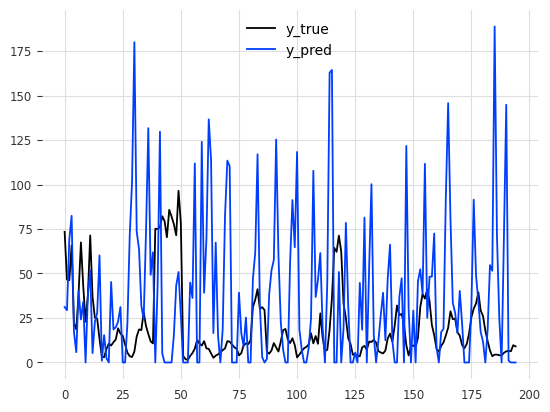

✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨1✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝


XGBModel(lags=3, lags_past_covariates=[-1, -2, -3], lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=quantile, quantiles=None, random_state=28, multi_models=True, use_static_covariates=True)

🐝Predict train nèkk
🐹🐹🐹🐹🐹🐹🐹🐹 df_train_year_month: 195
🌷 <TimeSeries (DataArray) (year_month: 198, component: 3, sample: 1)>
array([[[1.       ],
        [0.575    ],
        [0.1401869]],

       [[0.       ],
        [0.575    ],
        [0.5070093]],

       [[0.5585839],
        [0.45     ],
        [0.564486 ]],

       [[0.3571228],
        [0.425    ],
        [0.453271 ]],

       [[0.4585558],
        [0.45     ],
        [0.938785 ]],

...

       [[0.5535263],
        [0.475    ],
        [0.0140187]],

       [[0.3315538],
        [0.65     ],
        [0.8364486]],

       [[0.7642596],
        [0.325    ],
        [0.9065421]],

       [[0.1404889],
        [0.575    ],
        [0.5      ]],

       [[0.4383254],
        [0.3      ],
        [0.5420561]]])
Coordinates:
  * year_month  (year_month) datetime64[ns] 2013-10-31 2013-11-30 ... 2030-03-31
  * component   (component) object 'Max_Daily_Rainfall' ... 'n_hours_sunshine'
Dimensions without coordinates: sample
Attribute

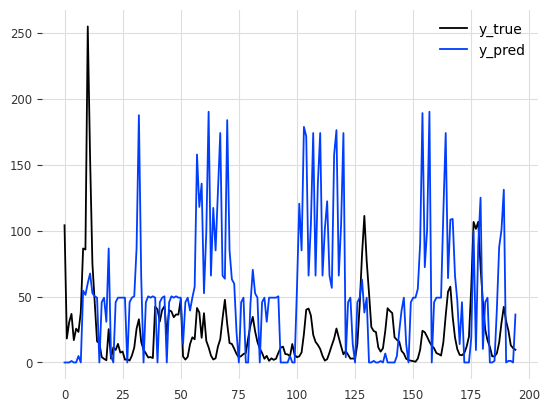

✨✨✨✨✨✨✨✨2✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝


XGBModel(lags=4, lags_past_covariates=[-2, -3, -4], lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=quantile, quantiles=None, random_state=14, multi_models=True, use_static_covariates=True)

🐝Predict train nèkk
🐹🐹🐹🐹🐹🐹🐹🐹 df_train_year_month: 195
🌷 <TimeSeries (DataArray) (year_month: 199, component: 3, sample: 1)>
array([[[0.4412563],
        [0.455184 ],
        [0.675    ]],

       [[0.8575998],
        [1.       ],
        [0.575    ]],

       [[0.2037611],
        [0.       ],
        [0.575    ]],

       [[0.5435246],
        [0.5585839],
        [0.45     ]],

       [[0.4850717],
        [0.3571228],
        [0.425    ]],

...

       [[0.4651028],
        [0.5535263],
        [0.475    ]],

       [[0.3807677],
        [0.3315538],
        [0.65     ]],

       [[0.6706088],
        [0.7642596],
        [0.325    ]],

       [[0.1384257],
        [0.1404889],
        [0.575    ]],

       [[0.5019387],
        [0.4383254],
        [0.3      ]]])
Coordinates:
  * year_month  (year_month) datetime64[ns] 2013-09-30 2013-10-31 ... 2030-03-31
  * component   (component) object 'Total_Rainfall' ... 'Min_Humidity'
Dimensions without coordinates: sample
Attributes:
    s

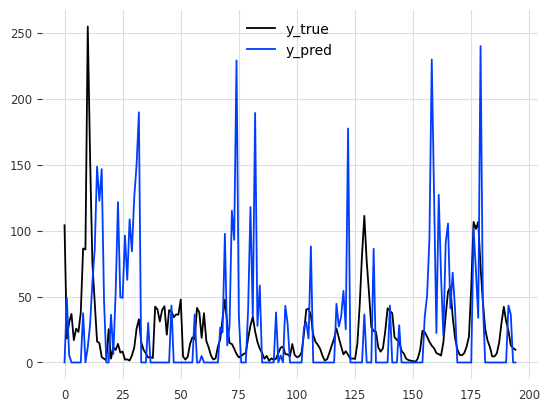

✨✨✨✨✨✨✨✨3✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝


XGBModel(lags=5, lags_past_covariates=[-3, -4, -5], lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=quantile, quantiles=None, random_state=17, multi_models=True, use_static_covariates=True)

🐝Predict train nèkk
🐹🐹🐹🐹🐹🐹🐹🐹 df_train_year_month: 195
🌷 <TimeSeries (DataArray) (year_month: 200, component: 3, sample: 1)>
array([[[0.3614191],
        [0.5      ],
        [0.4615385]],

       [[0.5484109],
        [0.4324324],
        [0.5076923]],

       [[0.4745011],
        [0.3513514],
        [0.4153846]],

       [[0.5905395],
        [0.4189189],
        [0.4769231]],

       [[0.5934959],
        [0.3918919],
        [0.6923077]],

...

       [[0.54915  ],
        [0.3648649],
        [0.3846154]],

       [[0.4752402],
        [0.472973 ],
        [0.6153846]],

       [[0.7782705],
        [0.3513514],
        [0.5076923]],

       [[0.6526238],
        [0.2972973],
        [0.5692308]],

       [[0.7930525],
        [0.1621622],
        [0.4769231]]])
Coordinates:
  * year_month  (year_month) datetime64[ns] 2013-08-31 2013-09-30 ... 2030-03-31
  * component   (component) object 'Total_Evaporation' ... 'Max_Absolute_Temp...
Dimensions without coordinates: sample
Attribu

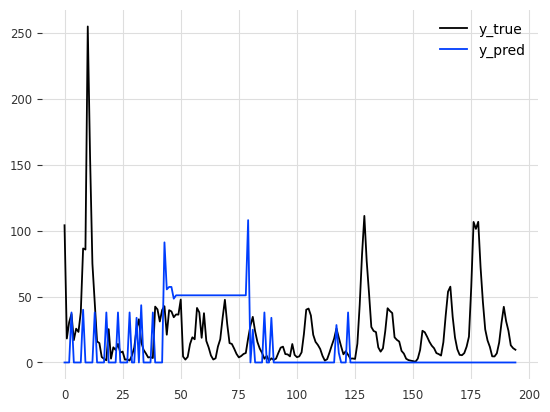

✨✨✨✨✨✨✨✨4✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝


XGBModel(lags=6, lags_past_covariates=[-4, -5, -6], lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=quantile, quantiles=None, random_state=26, multi_models=True, use_static_covariates=True)

🐝Predict train nèkk
🐹🐹🐹🐹🐹🐹🐹🐹 df_train_year_month: 195
🌷 <TimeSeries (DataArray) (year_month: 201, component: 3, sample: 1)>
array([[[0.3230769],
        [0.8691589],
        [0.8      ]],

       [[0.4615385],
        [0.5607477],
        [0.775    ]],

       [[0.5076923],
        [0.4953271],
        [0.675    ]],

       [[0.4153846],
        [0.5233645],
        [0.575    ]],

       [[0.4769231],
        [0.5327103],
        [0.575    ]],

...

       [[0.3846154],
        [0.5233645],
        [0.475    ]],

       [[0.6153846],
        [0.5700935],
        [0.65     ]],

       [[0.5076923],
        [0.4018692],
        [0.325    ]],

       [[0.5692308],
        [0.3831776],
        [0.575    ]],

       [[0.4769231],
        [0.2897196],
        [0.3      ]]])
Coordinates:
  * year_month  (year_month) datetime64[ns] 2013-07-31 2013-08-31 ... 2030-03-31
  * component   (component) object 'Max_Absolute_Temperature' ... 'Min_Humidity'
Dimensions without coordinates: sample
Attribu

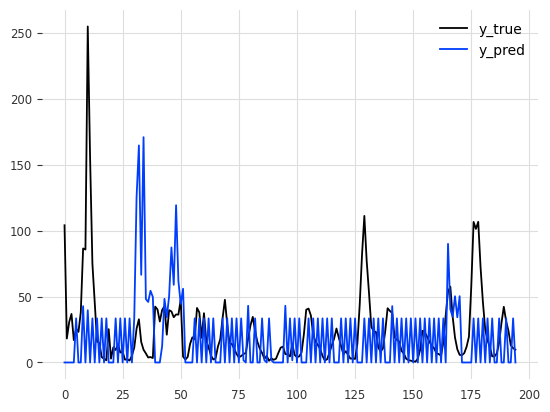

✨✨✨✨✨✨✨✨5✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝


XGBModel(lags=7, lags_past_covariates=[-5, -6, -7], lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=quantile, quantiles=None, random_state=1, multi_models=True, use_static_covariates=True)

🐝Predict train nèkk
🐹🐹🐹🐹🐹🐹🐹🐹 df_train_year_month: 195
🌷 <TimeSeries (DataArray) (year_month: 202, component: 3, sample: 1)>
array([[[0.4349536],
        [0.9230769],
        [0.325    ]],

       [[0.5892105],
        [0.3230769],
        [0.8      ]],

       [[0.4779432],
        [0.4615385],
        [0.775    ]],

       [[0.455184 ],
        [0.5076923],
        [0.675    ]],

       [[1.       ],
        [0.4153846],
        [0.575    ]],

...

       [[0.5535263],
        [0.3846154],
        [0.475    ]],

       [[0.3315538],
        [0.6153846],
        [0.65     ]],

       [[0.7642596],
        [0.5076923],
        [0.325    ]],

       [[0.1404889],
        [0.5692308],
        [0.575    ]],

       [[0.4383254],
        [0.4769231],
        [0.3      ]]])
Coordinates:
  * year_month  (year_month) datetime64[ns] 2013-06-30 2013-07-31 ... 2030-03-31
  * component   (component) object 'Max_Daily_Rainfall' ... 'Min_Humidity'
Dimensions without coordinates: sample
Attributes:
 

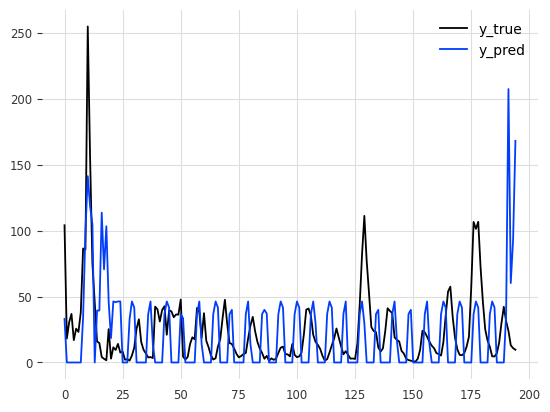

✨✨✨✨✨✨✨✨6✨✨✨✨✨✨✨✨✨✨
🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝


XGBModel(lags=8, lags_past_covariates=[-6, -7, -8], lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=quantile, quantiles=None, random_state=35, multi_models=True, use_static_covariates=True)

🐝Predict train nèkk
🐹🐹🐹🐹🐹🐹🐹🐹 df_train_year_month: 195
🌷 <TimeSeries (DataArray) (year_month: 203, component: 3, sample: 1)>
array([[[0.7846154],
        [0.5609756],
        [0.625    ]],

       [[0.9230769],
        [0.3902439],
        [0.325    ]],

       [[0.3230769],
        [0.5853659],
        [0.8      ]],

       [[0.4615385],
        [0.5853659],
        [0.775    ]],

       [[0.5076923],
        [0.4634146],
        [0.675    ]],

...

       [[0.3846154],
        [0.4878049],
        [0.475    ]],

       [[0.6153846],
        [0.5365854],
        [0.65     ]],

       [[0.5076923],
        [0.3658537],
        [0.325    ]],

       [[0.5692308],
        [0.2926829],
        [0.575    ]],

       [[0.4769231],
        [0.4146341],
        [0.3      ]]])
Coordinates:
  * year_month  (year_month) datetime64[ns] 2013-05-31 2013-06-30 ... 2030-03-31
  * component   (component) object 'Max_Absolute_Temperature' ... 'Min_Humidity'
Dimensions without coordinates: sample
Attribu

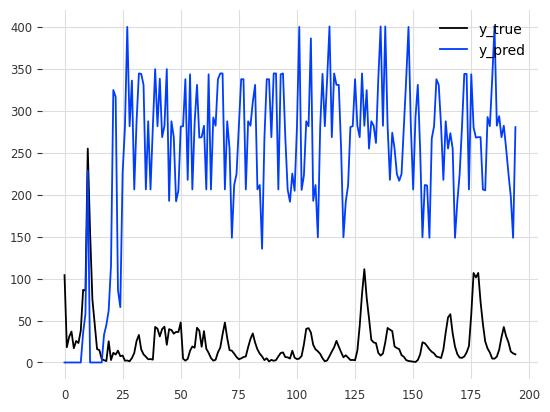

In [15]:
# sklearn_model_list =[
#     "PoissonRegressor",
#     "SVMRBF"
# ]
dart_model_list =[
    #  "RandomForest",
    #  "LinearRegressionModel",
     "LightGBMModel",
    #  "CatBoostModel",
    #  "XGBModel",
]

model_name_list = dart_model_list
is_sklearn_model = 0
is_pred_on_train_list = [0,1] #first for train, then for test
data_set = {
  0: "test",
  1: "train"
}
labels = args.labels
for is_pred_on_train in is_pred_on_train_list:
    for model_name in model_name_list:   
        print(f"⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️{model_name}⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️")
        for city in cities:
            print(f"✨✨✨✨✨✨✨✨{city}✨✨✨✨✨✨✨✨✨✨")
            df_results = pd.DataFrame()
            
            for nstep in range(1,args.n_predicted_period_months+1):
            # for nstep in range(1,2):
                print(f"✨✨✨✨✨✨✨✨{nstep}✨✨✨✨✨✨✨✨✨✨")
                df_train = pd.read_csv(output_process+city+'_train_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
                df_eval = pd.read_csv(output_process+city+'_test_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
                scaler = joblib.load(output_process+city+'_train_scalerMinMaxNorm.save') #ok
                feature_list = getDataWithSelectedFeature(city, nstep)

                train_size = len(df_train) - args.look_back - args.n_predicted_period_months + 1  #195
                

                load_model_path = f"{model_path}{model_name}/{nstep}nstep_denguefever_{model_name}_in_{city}.sav"
                model = pickle.load(open(load_model_path, 'rb'))

                if is_sklearn_model == 1:
                    print("🐝🐝🐝🐝Predict SKLEARN One-output model🐝🐝🐝")
                    if is_pred_on_train == 1:
                        #############predict train#############
                        print("🐝Predict train nèkk")
                        buffer_size = args.look_back + nstep - 1
                        

                        df_train = df_train[- train_size - buffer_size: ] #Fit size of the test by step
                        train = df_train[feature_list+[args.labels]].iloc[:,:].to_numpy()
                        x_train,y_train = to_supervised(train, d_out=nstep, d_in=args.look_back )
                        x_train = x_train.reshape(len(x_train),x_train.shape[1]*x_train.shape[2])
                        
                        prediction = model.predict(x_train)
                        print(f"Total len(x_train) is {len(prediction)}/{train_size}")

                        df_eval_true_inverse = df_eval_pred_inverse = df_train[-train_size:]
                        y_true = scaler.inverse_transform(df_eval_true_inverse.iloc[:,:-1])[:,[-1]].reshape(len(prediction))

                        df_eval_pred_inverse[labels]= prediction
                        y_pred = scaler.inverse_transform(df_eval_pred_inverse.iloc[:,:-1])[:,[-1]].reshape(len(prediction))
                        y_pred = np.where(y_pred < 0, 0, y_pred)

                        mse = mean_squared_error(y_true, y_pred)
                        mae = mean_absolute_error(y_true, y_pred)
                        rmse = mse**0.5
                        mape = mean_absolute_percentage_error(y_true, y_pred)

                        df_results["Date"] = df_train["year_month"][- train_size:]
                        df_results["City"] = city
                        df_results["Observed"] = y_true
                        df_results[f"{nstep}-month"] = y_pred
                        df_results[f"MSE_{nstep}-month"] = mse
                        df_results[f"MAE_{nstep}-month"] = mae
                        df_results[f"RMSE_{nstep}-month"] = rmse
                        df_results[f"MAPE_{nstep}-month"] = mape
                        
                    else:
                        #############predict xtest#############
                        print("🐝Predict test nèkk")
                        train = df_train[feature_list+[args.labels]].iloc[:,:].to_numpy()
                        df_eval = df_eval[-args.test_size - args.look_back-(nstep - 1): ] #Fit size of the test by step
                        test = df_eval[feature_list+[args.labels]].iloc[:,:].to_numpy()
                        x_train,y_train = to_supervised(train, d_out=nstep, d_in=args.look_back )
                        x_train = x_train.reshape(len(x_train),x_train.shape[1]*x_train.shape[2])
                        x_test,y_test = to_supervised(test, d_out=nstep, d_in=args.look_back )
                        x_test = x_test.reshape(len(x_test),x_test.shape[1]*x_test.shape[2])
                        
                        prediction = model.predict(x_test)
                        print(f"Total len(x_test) is {len(prediction)}/{args.test_size}")
                        df_eval = df_eval[-args.test_size:]
                        y_true = df_eval[labels].values

                        df_eval_pred_inverse = df_eval[-args.test_size:]
                        df_eval_pred_inverse[labels]= prediction
                        y_pred = scaler.inverse_transform(df_eval_pred_inverse.iloc[:,:-1])[:,[-1]].reshape(len(prediction))  
                        y_pred = np.where(y_pred < 0, 0, y_pred)

                        mse = mean_squared_error(y_true, y_pred)
                        mae = mean_absolute_error(y_true, y_pred)
                        rmse = mse**0.5
                        mape = mean_absolute_percentage_error(y_true, y_pred)

                        df_results["Date"] = df_eval["year_month"][- args.test_size:]
                        df_results["City"] = city
                        df_results["Observed"] = y_true
                        df_results[f"{nstep}-month"] = y_pred
                        df_results[f"MSE_{nstep}-month"] = mse
                        df_results[f"MAE_{nstep}-month"] = mae
                        df_results[f"RMSE_{nstep}-month"] = rmse
                        df_results[f"MAPE_{nstep}-month"] = mape
                #############################################
                else:
                    print("🐝🐝🐝🐝Predict DARTS One-output model🐝🐝🐝")
                    if is_pred_on_train == 1:
                        #############predict xtrain#############
                        display(model)
                        print("🐝Predict train nèkk")
                        buffer_size = args.look_back + nstep - 1
                        print("🐹🐹🐹🐹🐹🐹🐹🐹 df_train_year_month:", len(df_train["year_month"][- train_size:]))
                        df_results["Date"] = df_train["year_month"][- train_size:]

                        df_train = df_train[- (train_size + buffer_size): ] #Fit size of the test by step
                        retime_start = str(df_train.tail(buffer_size+1)["year_month"].values[0])
                        df_train_retime = retime_train(retime_start, len(df_train))
                        df_train["year_month"] = df_train_retime

                        
                        x_train = TimeSeries.from_dataframe(df_train, "year_month", feature_list)
                        y_train = TimeSeries.from_dataframe(df_train, "year_month", labels)

                        prediction = model.predict(train_size, past_covariates = x_train, num_samples=1)
                        # print(f"Total len(x_train) is {len(prediction)}/{train_size}")

                        
                        df_eval_true_inverse = df_eval_pred_inverse = df_train[-train_size:]
                        y_true = scaler.inverse_transform(df_eval_true_inverse.iloc[:,:-1])[:,[-1]].reshape(len(prediction))
                        df_eval_pred_inverse[labels]= np.array(prediction._xa).squeeze()
                        y_pred = scaler.inverse_transform(df_eval_pred_inverse.iloc[:,:-1])[:,[-1]].reshape(len(prediction)) 
                        y_pred = np.where(y_pred < 0, 0, y_pred)

                        mse = mean_squared_error(y_true, y_pred)
                        mae = mean_absolute_error(y_true, y_pred)
                        rmse = mse**0.5
                        mape = mean_absolute_percentage_error(y_true, y_pred)

                        df_results["City"] = city
                        df_results["Observed"] = y_true
                        df_results[f"{nstep}-month"] = y_pred
                        df_results[f"MSE_{nstep}-month"] = mse
                        df_results[f"MAE_{nstep}-month"] = mae
                        df_results[f"RMSE_{nstep}-month"] = rmse
                        df_results[f"MAPE_{nstep}-month"] = mape
                    else:
                        #############predict xtest#############
                        print("🐝Predict test nèkk")
                        x_train = TimeSeries.from_dataframe(df_train, "year_month", feature_list)
                        y_train = TimeSeries.from_dataframe(df_train, "year_month", labels)

                        df_eval = df_eval[-args.test_size - args.look_back-(nstep - 1): ]

                        x_test = TimeSeries.from_dataframe(df_eval, "year_month", feature_list)
                        y_test = TimeSeries.from_dataframe(df_eval, "year_month", labels)

                        # Create the  model
                        lags_by_nstep = args.look_back + nstep - 1
                        lags_past_covariates_by_nstep = [-lags_by_nstep+2,-lags_by_nstep+1,-lags_by_nstep] #Mảng này chứa ba giá trị tương ứng cho args.lookback 3

                        prediction = model.predict(args.test_size, past_covariates = x_test, num_samples=1)
                        print(f"Total len(_test) is {len(prediction)}/{args.test_size}")

                        df_eval = df_eval[-args.test_size:]
                        y_true = df_eval[labels].values
                        df_eval[labels]= np.array(prediction._xa).squeeze()
                        y_pred = scaler.inverse_transform(df_eval.iloc[:,:-1])[:,[-1]].reshape(len(prediction))
                        y_pred = np.where(y_pred < 0, 0, y_pred)

                        mse = mean_squared_error(y_true, y_pred)
                        mae = mean_absolute_error(y_true, y_pred)
                        rmse = mse**0.5
                        mape = mean_absolute_percentage_error(y_true, y_pred)

                        df_results["Date"] = df_eval["year_month"][- args.test_size:]
                        df_results["City"] = city
                        df_results["Observed"] = y_true
                        df_results[f"{nstep}-month"] = y_pred
                        df_results[f"MSE_{nstep}-month"] = mse
                        df_results[f"MAE_{nstep}-month"] = mae
                        df_results[f"RMSE_{nstep}-month"] = rmse
                        df_results[f"MAPE_{nstep}-month"] = mape

                # df_results[f"RMSE_{nstep}-month"] = rmse
                # df_results[f"MAE_{nstep}-month"] = mae
                # df_results[f"MAPE_{nstep}-month"] = mape
                # df_results[f"MSE_{nstep}-month"] = mse
                
                df_compare_test_predict = pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
                df_compare_test_predict.plot()
                plt.legend()
                plt.show()
            result_columns = ['Date', 'City', 'Observed',
                                'MSE_1-month', 'MAE_1-month', 'RMSE_1-month', 'MAPE_1-month',  
                                'MSE_2-month', 'MAE_2-month', 'RMSE_2-month', 'MAPE_2-month',  
                                'MSE_3-month', 'MAE_3-month', 'RMSE_3-month', 'MAPE_3-month',
                                'MSE_4-month', 'MAE_4-month', 'RMSE_4-month', 'MAPE_4-month', 
                                'MSE_5-month', 'MAE_5-month', 'RMSE_5-month', 'MAPE_5-month',  
                                'MSE_6-month', 'MAE_6-month', 'RMSE_6-month', 'MAPE_6-month',
                                '1-month', '2-month', '3-month', '4-month', '5-month', '6-month', 
                                ]
            df_results = df_results.reset_index()[result_columns]
            # display(df_results)

            folder_save_path = f'./metric_results/{model_name}/'
            if not (os.path.isdir(folder_save_path)):
                os.makedirs(folder_save_path, exist_ok=True)
            df_results.to_excel(f"{folder_save_path}0_{data_set[is_pred_on_train]}_allnstep_denguefever_prediction_results_by_{model_name}_in_{city}.xlsx")

# Load results for multi-step-output model

In [16]:
# # sarima_model_list =[
# #     "SARIMA",
# # ]
# dart_model_list =[
#      "BlockRNNModel",
#      "NBEATSModel",
#      "NHiTSModel",
#      "TFTModel",
# ]

# model_name_list = dart_model_list
# sarima_model_list = 0
# is_pred_on_train = 1

# labels = args.labels

# for model_name in model_name_list:   
#     print(f"✨✨✨✨✨✨✨✨{model_name}✨✨✨✨✨✨✨✨✨✨")
#     for city in cities:
#         print(f"✨✨✨✨✨✨✨✨{city}✨✨✨✨✨✨✨✨✨✨")
#         df_results = pd.DataFrame()
#         df_train = pd.read_csv(output_process+city+'_train_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
#         df_eval = pd.read_csv(output_process+city+'_test_preprocessed_normed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
#         df_full = pd.concat([df_train, df_eval[args.n_predicted_period_months + args.look_back -1 :]], ignore_index=True, sort=False)

#         scaler = joblib.load(output_process+city+'_train_scalerMinMaxNorm.save') #ok
#         nstep = args.n_predicted_period_months
#         feature_list = getDataWithSelectedFeature(city, nstep)
#         df_hyper_params = getHyperParamsForMultiOutput(model_name, city)

#         train_size = len(df_train) - args.look_back - args.n_predicted_period_months + 1  #195

#         if sarima_model_list == 1:
#             print("🐝🐝🐝🐝Predict SARIMA multi-output model🐝🐝🐝")
#             ##############Just predict on test#############
#             print("🐝Predict test nèkk")
#             print("🐹model_name:",model_name)
#             if model_name == "SARIMA":
#                 p = df_hyper_params['p'].values[0]
#                 d = df_hyper_params['d'].values[0]
#                 q = df_hyper_params['q'].values[0]
#                 t = df_hyper_params['t'].values[0]
#                 P = df_hyper_params['P'].values[0]
#                 D = df_hyper_params['D'].values[0]
#                 Q = df_hyper_params['Q'].values[0]
#                 m = df_hyper_params['m'].values[0]
#                 cfg = [(p, d, q), (P, D, Q, m), t]
#                 order, sorder, trend = cfg
            
#             trainlist = [x for x in df_full.Dengue_fever_rates]
#             nstep = args.n_predicted_period_months

#             predict_list = []
#             for i in range (args.test_size+(nstep-1)):
#                 history = trainlist[:-args.test_size-(nstep-1-i)]
#                 model = SARIMAX(history, 
#                                 order=order, 
#                                 seasonal_order=sorder, 
#                                 trend = trend,
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False)
#                 model_fit = model.fit(disp=False)
#                 yhat = model_fit.predict(len(history), len(history) + nstep - 1)
#                 predict_list.append(yhat)

#             y_pred_list = []
#             for step in range(nstep):
#                 moving = nstep-1-step
#                 y_pred_list.append([x[step] for x in predict_list][moving:args.test_size+moving])

#             df_eval_true_inverse = df_full[-args.test_size:]
#             y_true = scaler.inverse_transform(df_eval_true_inverse.iloc[:,:-1])[:,[-1]].reshape(args.test_size)

#             y_pred_inverse_list = []
#             for step in range(nstep):
#                 df_eval_pred_inverse = df_full[-args.test_size:]
#                 df_eval_pred_inverse[args.labels]= y_pred_list[step] #step 1
#                 y_pred_inverse = scaler.inverse_transform(df_eval_pred_inverse.iloc[:,:-1])[:,[-1]].reshape(args.test_size)
#                 y_pred_inverse = np.where(y_pred_inverse < 0, 0, y_pred_inverse)

#                 y_pred_inverse_list.append(y_pred_inverse)
#                 df_compare_test_predict = pd.DataFrame({'y_true':y_true, 'y_pred':y_pred_inverse})
#                 df_compare_test_predict.plot()
#                 plt.legend()
#                 plt.show()

#             df_results["Date"] = df_eval["year_month"][- args.test_size:]
#             df_results["City"] = city
#             df_results["Observed"] = y_true

#             for step in range(args.n_predicted_period_months):
#                 df_results[f"MSE_{step+1}-month"] = mean_squared_error(y_true, y_pred_inverse_list[step])
#                 df_results[f"MAE_{step+1}-month"] = mean_absolute_error(y_true, y_pred_inverse_list[step])
#                 df_results[f"RMSE_{step+1}-month"] = mean_squared_error(y_true, y_pred_inverse_list[step])**0.5
#                 df_results[f"MAPE_{step+1}-month"] = mean_absolute_percentage_error(y_true, y_pred_inverse_list[step])
#                 df_results[f"{step+1}-month"] = y_pred_inverse_list[step]
#         else:
#             print("🐝🐝🐝🐝Predict DARTS multi-output model🐝🐝🐝")
#             load_model_path = f"{model_path}{model_name}/{nstep}nstep_denguefever_{model_name}_in_{city}.sav"
#             model = pickle.load(open(load_model_path, 'rb'))
#             if is_pred_on_train == 1:
#                 #############predict xtrain#############
#                 print("🐝Predict train nèkk")
#                 buffer_size = args.look_back + nstep - 1
#                 print("🐹🐹🐹🐹🐹🐹🐹🐹 df_train_year_month:", len(df_train["year_month"][- train_size:]))
#                 df_results["Date"] = df_train["year_month"][- train_size:]
#                 df_eval_t = df_train[- (train_size + buffer_size): ] #Fit size of the test(train) by step

#                 retime_start = str(df_train.tail(buffer_size+1)["year_month"].values[0])
                
#                 df_eval_t_retime = retime_train(retime_start, len(df_eval_t))
#                 df_eval_t["year_month"] = df_eval_t_retime


#                 x_train = TimeSeries.from_dataframe(df_train, "year_month", feature_list)
#                 y_train = TimeSeries.from_dataframe(df_train, "year_month", labels)
#                 x_test = TimeSeries.from_dataframe(df_eval_t, "year_month", feature_list)
#                 y_test = TimeSeries.from_dataframe(df_eval_t, "year_month", labels)

#                 #Cách một khoảng phần này cho x_train thì mới đưa đc chuỗi x_test vừa đủ để dự đoán 36 lần 6step
#                     # ValueError: For the given forecasting horizon `n=xxx`, the provided 
#                     # past covariates at dataset index `0` do not extend far enough into 
#                     # the future. As `n > output_chunk_length` the past covariates must 
#                     # start at time step `xxxxxx`, whereas now they start at 
#                     # time step `xxxxx`.

#                 x_train_back = x_train[:-(args.n_predicted_period_months-1)]
#                 y_train_back = y_train[:-(args.n_predicted_period_months-1)]

#                 predict_list = []
#                 for i in range (train_size+(args.n_predicted_period_months-1)):
#                     model.fit(y_train_back, past_covariates = x_train_back)
#                     prediction = model.predict(6)
                    
#                     x_train_back = x_train_back.append(x_test[i+3])
#                     predict_list.append(np.array(prediction._xa).squeeze())
#                 y_pred_list = []
#                 for step in range(args.n_predicted_period_months):
#                     moving = args.n_predicted_period_months-1-step
#                     y_pred_list.append([x[step] for x in predict_list][moving:train_size+moving])

#                 df_eval_true_inverse = df_train[-train_size:]
#                 y_true = scaler.inverse_transform(df_eval_true_inverse.iloc[:,:-1])[:,[-1]].reshape(train_size)

#                 y_pred_inverse_list = []
#                 for step in range(args.n_predicted_period_months):
#                     df_eval_pred_inverse = df_train[-train_size:]
#                     df_eval_pred_inverse[args.labels]= y_pred_list[step] #step 1
#                     y_pred_inverse = scaler.inverse_transform(df_eval_pred_inverse.iloc[:,:-1])[:,[-1]].reshape(train_size)
#                     y_pred_inverse = np.where(y_pred_inverse < 0, 0, y_pred_inverse)
                    
#                     y_pred_inverse_list.append(y_pred_inverse)
#                     df_compare_test_predict = pd.DataFrame({'y_true':y_true, 'y_pred':y_pred_inverse})
#                     df_compare_test_predict.plot()
#                     plt.legend()
#                     plt.savefig(f"./visuallize/{model_name}/0_train_6nstep_denguefever_prediction_results_by_{model_name}_in_{city}.png")
#                 df_results["Date"] = df_train["year_month"][- train_size:]
#                 df_results["City"] = city
#                 df_results["Observed"] = y_true

#                 for step in range(args.n_predicted_period_months):
#                     df_results[f"MSE_{step+1}-month"] = mean_squared_error(y_true, y_pred_inverse_list[step])
#                     df_results[f"MAE_{step+1}-month"] = mean_absolute_error(y_true, y_pred_inverse_list[step])
#                     df_results[f"RMSE_{step+1}-month"] = mean_squared_error(y_true, y_pred_inverse_list[step])**0.5
#                     df_results[f"MAPE_{step+1}-month"] = mean_absolute_percentage_error(y_true, y_pred_inverse_list[step])
#                     df_results[f"{step+1}-month"] = y_pred_inverse_list[step]
            
#             else:
#                 #############predict xtest#############
#                 print("🐝Predict test nèkk")
#                 x_train = TimeSeries.from_dataframe(df_train, "year_month", feature_list)
#                 y_train = TimeSeries.from_dataframe(df_train, "year_month", labels)
#                 x_test = TimeSeries.from_dataframe(df_eval, "year_month", feature_list)
#                 y_test = TimeSeries.from_dataframe(df_eval, "year_month", labels)

#                 #Cách một khoảng phần này cho x_train thì mới đưa đc chuỗi x_test vừa đủ để dự đoán 36 lần 6step
#                     # ValueError: For the given forecasting horizon `n=xxx`, the provided 
#                     # past covariates at dataset index `0` do not extend far enough into 
#                     # the future. As `n > output_chunk_length` the past covariates must 
#                     # start at time step `xxxxxx`, whereas now they start at 
#                     # time step `xxxxx`.

#                 x_train_back = x_train[:-(args.n_predicted_period_months-1)]
#                 y_train_back = y_train[:-(args.n_predicted_period_months-1)]

#                 predict_list = []
#                 for i in range (args.test_size+(args.n_predicted_period_months-1)):
#                     model.fit(y_train_back, past_covariates = x_train_back)
#                     prediction = model.predict(6)
#                     x_train_back = x_train_back.append(x_test[i+3])
#                     predict_list.append(np.array(prediction._xa).squeeze())
#                 y_pred_list = []
#                 for step in range(args.n_predicted_period_months):
#                     moving = args.n_predicted_period_months-1-step
#                     y_pred_list.append([x[step] for x in predict_list][moving:args.test_size+moving])

#                 df_eval_true_inverse = df_eval[-args.test_size:]
#                 y_true = scaler.inverse_transform(df_eval_true_inverse.iloc[:,:-1])[:,[-1]].reshape(args.test_size)

#                 y_pred_inverse_list = []
#                 for step in range(args.n_predicted_period_months):
#                     df_eval_pred_inverse = df_eval[-args.test_size:]
#                     df_eval_pred_inverse[args.labels]= y_pred_list[step] #step 1

#                     y_pred_inverse = scaler.inverse_transform(df_eval_pred_inverse.iloc[:,:-1])[:,[-1]].reshape(args.test_size)
#                     y_pred_inverse = np.where(y_pred_inverse < 0, 0, y_pred_inverse)

#                     y_pred_inverse_list.append(y_pred_inverse)
#                     df_compare_test_predict = pd.DataFrame({'y_true':y_true, 'y_pred':y_pred_inverse})
#                     df_compare_test_predict.plot()
#                     plt.legend()
#                     plt.show()
                
#                 df_results["Date"] = df_eval["year_month"][- args.test_size:]
#                 df_results["City"] = city
#                 df_results["Observed"] = y_true

#                 for step in range(args.n_predicted_period_months):
#                     df_results[f"MSE_{step+1}-month"] = mean_squared_error(y_true, y_pred_inverse_list[step])
#                     df_results[f"MAE_{step+1}-month"] = mean_absolute_error(y_true, y_pred_inverse_list[step])
#                     df_results[f"RMSE_{step+1}-month"] = mean_squared_error(y_true, y_pred_inverse_list[step])**0.5
#                     df_results[f"MAPE_{step+1}-month"] = mean_absolute_percentage_error(y_true, y_pred_inverse_list[step])
#                     df_results[f"{step+1}-month"] = y_pred_inverse_list[step]

#         result_columns = ['Date', 'City', 'Observed',
#                             'MSE_1-month', 'MAE_1-month', 'RMSE_1-month', 'MAPE_1-month',  
#                             'MSE_2-month', 'MAE_2-month', 'RMSE_2-month', 'MAPE_2-month',  
#                             'MSE_3-month', 'MAE_3-month', 'RMSE_3-month', 'MAPE_3-month',
#                             'MSE_4-month', 'MAE_4-month', 'RMSE_4-month', 'MAPE_4-month', 
#                             'MSE_5-month', 'MAE_5-month', 'RMSE_5-month', 'MAPE_5-month',  
#                             'MSE_6-month', 'MAE_6-month', 'RMSE_6-month', 'MAPE_6-month',
#                             '1-month', '2-month', '3-month', '4-month', '5-month', '6-month', 
#                             ]
#         df_results = df_results.reset_index()[result_columns]

#         display(df_results)
#         folder_save_path = f'./metric_results/{model_name}/'
#         if not (os.path.isdir(folder_save_path)):
#             os.makedirs(folder_save_path, exist_ok=True)
#         df_results.to_excel(f"{folder_save_path}0_{data_set[is_pred_on_train]}_allnstep_denguefever_prediction_results_by_{model_name}_in_{city}.xlsx")
        

# Visuallize

✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


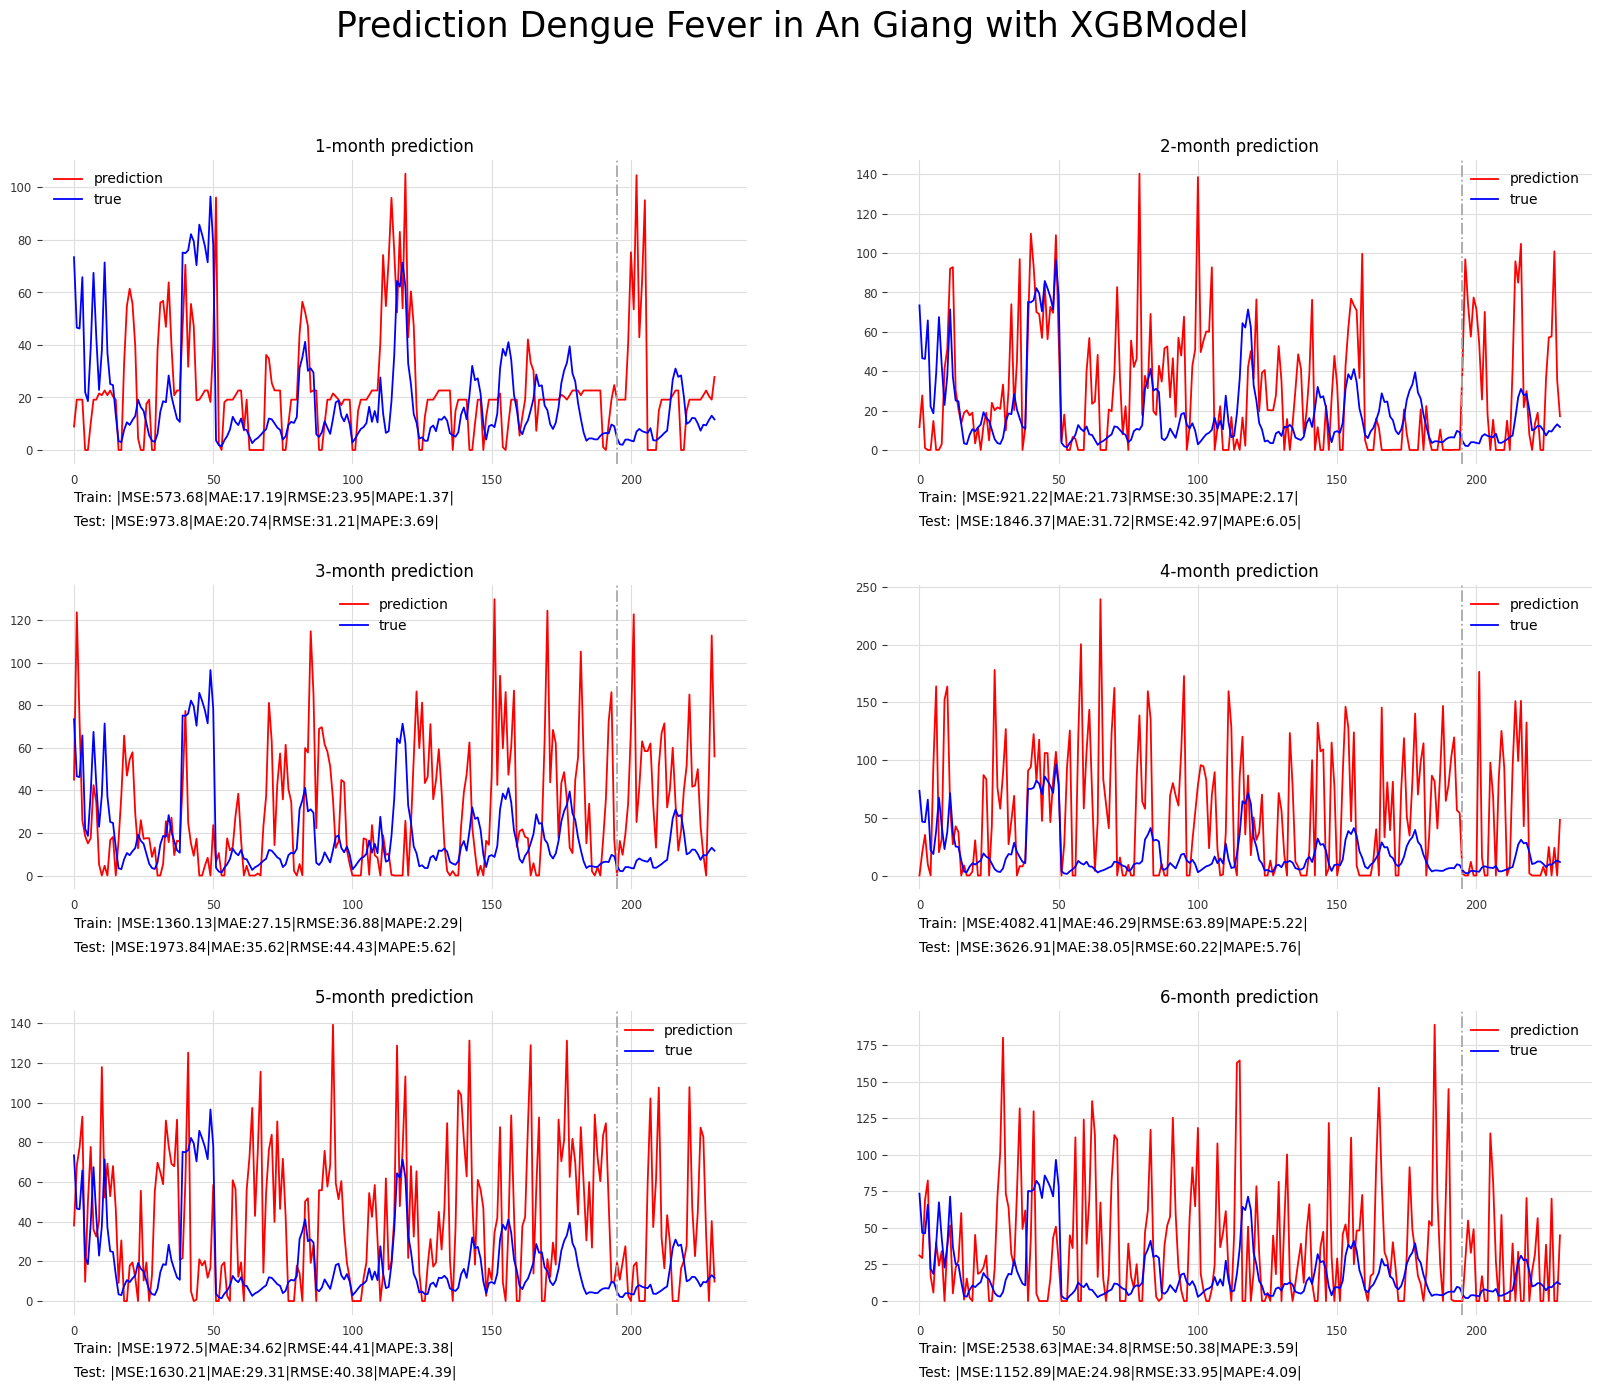

✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


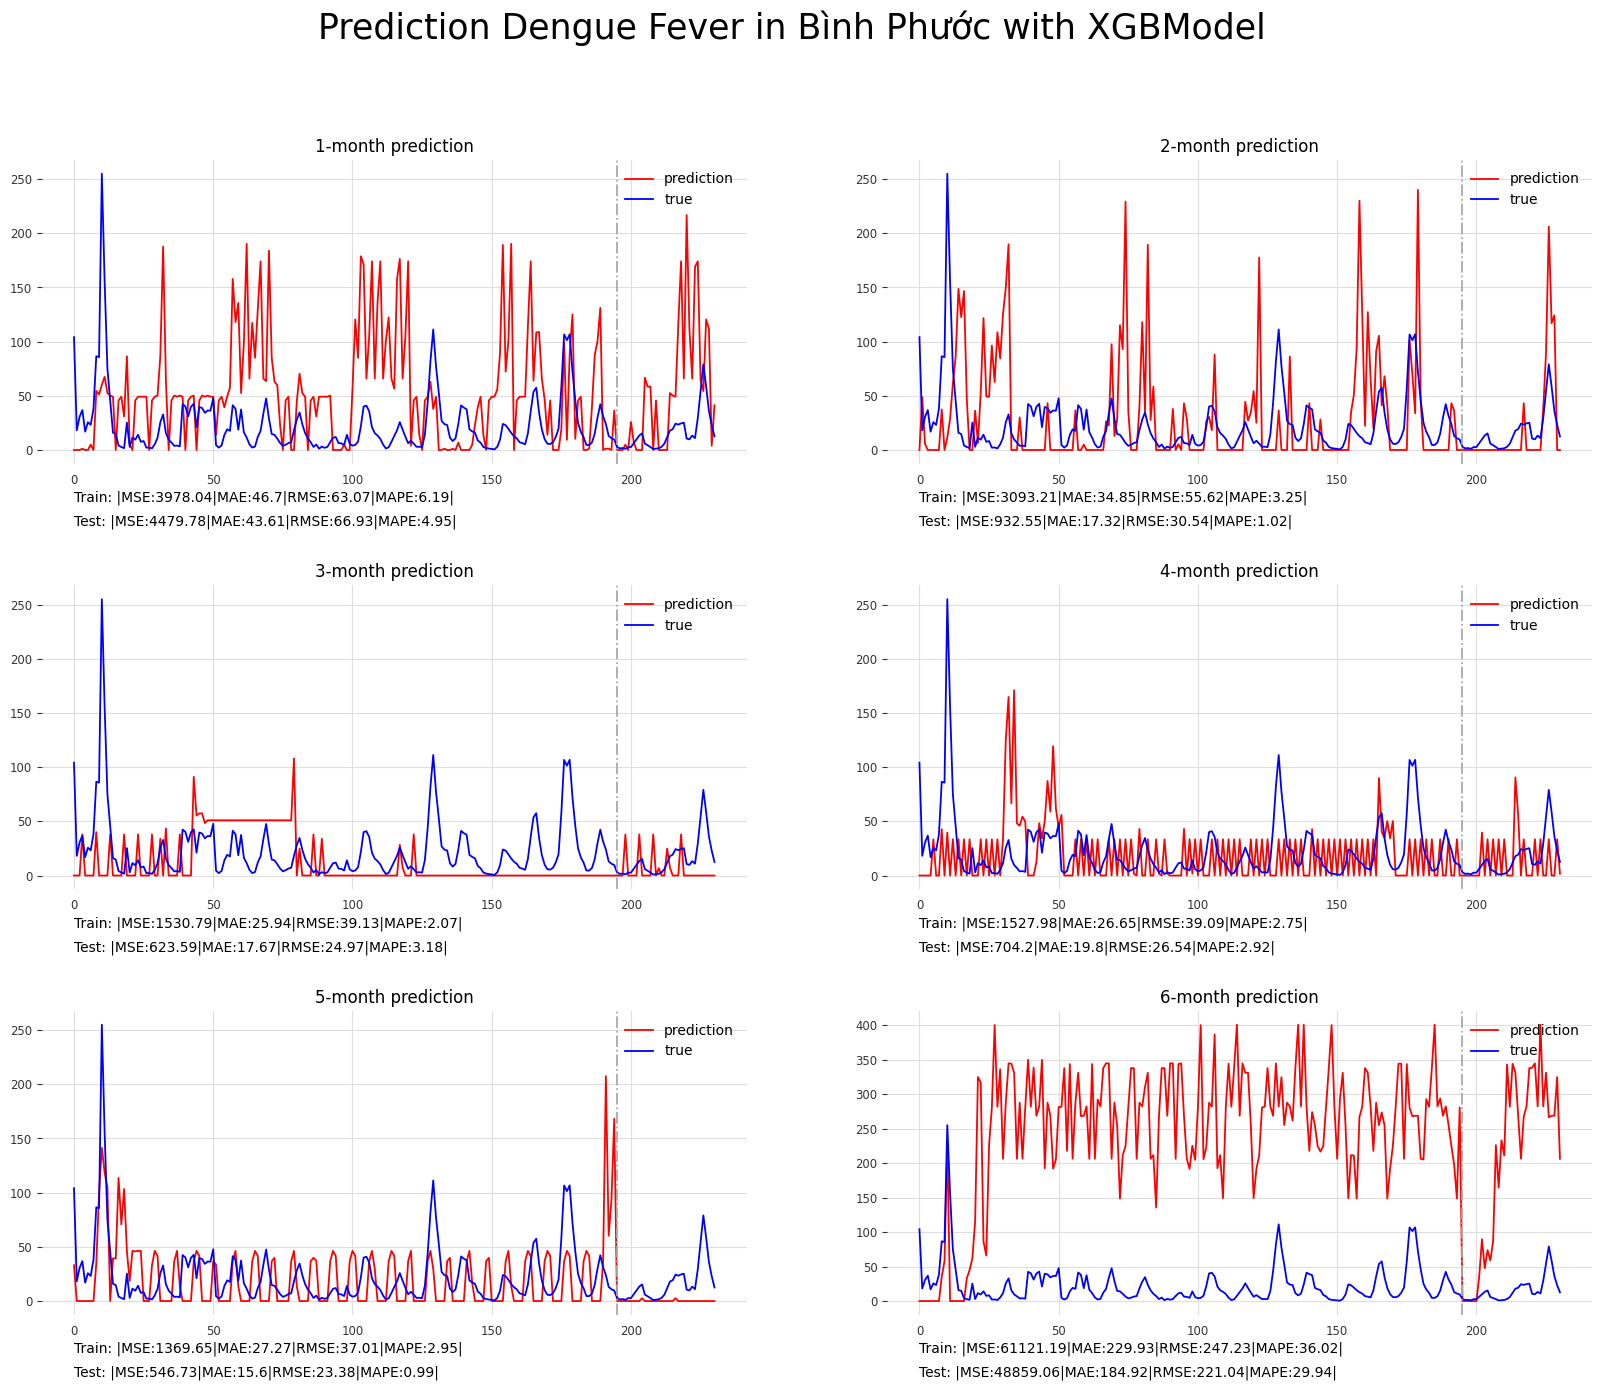

In [17]:
for model_name in model_name_list:   
    print(f"✨✨✨✨✨✨✨✨{model_name}✨✨✨✨✨✨✨✨✨✨")
    for city in cities:
        print(f"✨✨✨✨✨✨✨✨{city}✨✨✨✨✨✨✨✨✨✨")
        folder_save_path = f'./metric_results/{model_name}/'
        city_result_test = pd.read_excel(f"{folder_save_path}0_{data_set[0]}_allnstep_denguefever_prediction_results_by_{model_name}_in_{city}.xlsx")
        city_result_train = pd.read_excel(f"{folder_save_path}0_{data_set[1]}_allnstep_denguefever_prediction_results_by_{model_name}_in_{city}.xlsx")
        fig = plt.figure()
        fig.set_figwidth(20)
        fig.set_figheight(15)
        plt.subplots_adjust(hspace=0.4)
        for nstep in range(1, args.n_predicted_period_months+1):
            #plot 1:
            #Test results
            mse_test = city_result_test[f'MSE_{nstep}-month'].values[0]
            mae_test = city_result_test[f'MAE_{nstep}-month'].values[0]
            rmse_test = city_result_test[f'RMSE_{nstep}-month'].values[0]
            mape_test = city_result_test[f'MAPE_{nstep}-month'].values[0]
            x_test = city_result_test[f'{nstep}-month'].values
            y_test = city_result_test[f'Observed'].values

            #Train results
            mse_train = city_result_train[f'MSE_{nstep}-month'].values[0]
            mae_train = city_result_train[f'MAE_{nstep}-month'].values[0]
            rmse_train = city_result_train[f'RMSE_{nstep}-month'].values[0]
            mape_train = city_result_train[f'MAPE_{nstep}-month'].values[0]
            x_train = city_result_train[f'{nstep}-month'].values
            y_train = city_result_train[f'Observed'].values
            plt.subplot(3, 2, nstep)
            x = np.concatenate((x_train, x_test))
            y = np.concatenate((y_train, y_test))
            plt.plot(x,color='red',label='prediction')
            plt.plot(y,color='blue',label='true')
            plt.axvline(x = len(x_train),linestyle="dashdot",color="#A9A9A9")

            plt.legend()
            plt.title(f"{nstep}-month prediction")
            plot_metric_point = np.max(np.concatenate((x, y)))
            plt.text(0, -(plot_metric_point/5), f'Train: |MSE:{round(mse_train, 2)}|MAE:{round(mae_train, 2)}|RMSE:{round(rmse_train, 2)}|MAPE:{round(mape_train, 2)}|', verticalalignment='bottom')
            plt.text(0, -(plot_metric_point/3.5), f'Test: |MSE:{round(mse_test, 2)}|MAE:{round(mae_test, 2)}|RMSE:{round(rmse_test, 2)}|MAPE:{round(mape_test, 2)}|', verticalalignment='bottom')
            
        plt.suptitle(f"Prediction Dengue Fever in {city} with {model_name}", fontsize=25)
        folder_save_path = f'./visuallize/{model_name}/'
        if not (os.path.isdir(folder_save_path)):
            os.makedirs(folder_save_path, exist_ok=True)
        plt.savefig(f"{folder_save_path}0_6nstep_denguefever_prediction_results_by_{model_name}_in_{city}.png")
        plt.show()
